## Dataset Loading

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from utilities import *
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import (train_test_split, cross_val_score, GridSearchCV, KFold)
from sklearn import (preprocessing, feature_extraction, 
                     linear_model, tree, svm, neighbors, naive_bayes, ensemble)
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import pickle
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload

train_og = pd.read_csv('train.csv', index_col=0)
train_og = train_og.copy()
test_X_og = pd.read_csv('test.csv', index_col=0)
test_X_og = test_X_og.copy()

print('train set shape:', train_og.shape)
print('test set shape:', test_X_og.shape)

train_X_og, train_Y_og = train_og[train_og.columns[1:]], train_og[train_og.columns[0]]

X_og = pd.concat([train_X_og, test_X_og])

train set shape: (891, 11)
test set shape: (418, 10)


## Feature Classification

In [2]:
categorical = ['Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked']
numerical = ['Age', 'Fare']

## Check Missing Values 

In [3]:
# print('train_Y missing value:', train_Y_og.isnull().sum())
# print()
# print('X_og missing value number:')
# print((X_og.isnull().sum()).sort_values(ascending=False)[:10])
# print()
# print('X_og missing value percentage:')
# print((X_og.isnull().sum()/len(X_og)).sort_values(ascending=False)[:10])
X_fill = X_og.copy()

## 'Cabin' Feature Missing Values

In [4]:
# missing_value(X_og['Cabin'])

X_og['Cabin'].describe()

X_fill['Cabin'] = X_fill['Cabin'].fillna('None')

## 'Age' Feature Missing Values 

In [5]:
# missing_value(X_og['Age'])

# describe_numerical(X_og['Age'])

X_fill['Age'] = X_fill['Age'].fillna(X_og['Age'].median())

## 'Embarked' & 'Fare' Feature Missing Values

In [6]:
# missing_value(X_og['Embarked'])

X_og['Embarked'].describe()

X_fill['Embarked'] = X_fill['Embarked'].fillna(X_og['Embarked'].describe()['top'])

# missing_value(X_og['Fare'])

# describe_numerical(X_og['Fare'])

X_fill['Fare'] = X_fill['Fare'].fillna(X_og['Fare'].median())

## Check Filled Missing Values

In [7]:
# print('X_fill missing value number:')
# print((X_fill.isnull().sum()).sort_values(ascending=False)[:10])
# print('X_fill missing value percentage:')
# print((X_fill.isnull().sum()/len(X_fill)).sort_values(ascending=False)[:10])

## Numerical Feature Skewness & Kurtosis

In [8]:
# print(X_fill[numerical].columns)

# plot_distribution(X_fill['Age'])

# plot_distribution(X_fill['Fare'])

X_fill['Fare'] = np.log1p(X_fill['Fare'])
# plot_distribution(X_fill['Fare'])

Index(['Age', 'Fare'], dtype='object')


## Add Feature 'Last Name' & Drop 'Name' Feature

for i in honorific:
    if re.findall('^[Mm].\.?$', i):
        print(i)

In [9]:
full_name = X_fill['Name'].str.split(',')

last_name = [i[0] for i in full_name.values]

X_fill['last name'] = last_name

In [10]:
X_fill = X_fill.drop('Name', axis=1)

## Drop 'Ticket' Feature

In [11]:
X_fill = X_fill.drop('Ticket', axis=1)

## Add Feature 'Cabin Class' & Drop 'Cabin' Feature

In [12]:
X_fill['cabin class'] = list(X_fill['Cabin'].str[0])

In [13]:
X_fill = X_fill.drop('Cabin', axis=1)

## Feature Value Transformation

In [14]:
X_pre_transform = X_fill.copy()

In [15]:
# print(X_pre_transform.columns)

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
       'last name', 'cabin class'],
      dtype='object')


In [16]:
numerical = ['Age', 'Fare']
nominal = ['Sex', 'Embarked']
ordinal = ['Pclass', 'cabin class']
last_name = 'last name'
no_transform = ['SibSp', 'Parch']

In [17]:
mapper = DataFrameMapper([
    (numerical, preprocessing.MinMaxScaler(feature_range=(0, 1))),
    (nominal, preprocessing.OneHotEncoder(sparse=False)), 
    (ordinal, preprocessing.OrdinalEncoder()),
    ('last name', feature_extraction.text.TfidfVectorizer()), 
    (no_transform, None)],
    df_out=True)

X_all = mapper.fit_transform(X_pre_transform)

In [18]:
print('X feature set shape:', X_all.shape)

X feature set shape: (1309, 905)


## Create Train, Dev, Test Sets

In [19]:
train_X = X_all.loc[train_X_og.index].to_numpy()
test_X = X_all.loc[test_X_og.index].to_numpy()

In [20]:
train_Y = train_Y_og.to_numpy()

In [21]:
train_X, dev_X, train_Y, dev_Y = train_test_split(train_X, train_Y, random_state=42)

## Model 7 - Neural Network

In [22]:
from keras.callbacks import History
from keras.models import Sequential
from keras.layers import Dense
from keras import losses
from keras import metrics
from keras import optimizers
from keras import initializers
from keras import regularizers

Using TensorFlow backend.


In [23]:
batch_size = 64
epochs = 200
lr = 0.001
l1 = 0.01
l2 = 0.01

In [24]:
model_nn, result = create_nn(train_X, train_Y, dev_X, dev_Y, l1, l2, lr, batch_size, epochs)

train set loss: 0.5878
dev set loss: 0.5742
train set accuracy: 0.8099
dev set accuracy: 0.8072


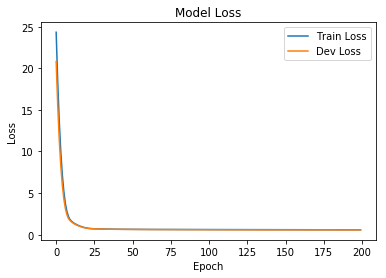

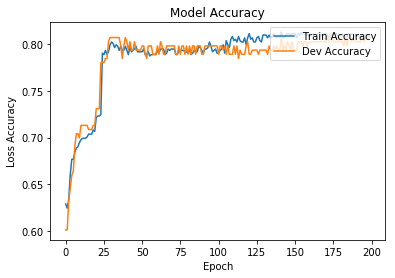

In [25]:
plot_result(result)

In [26]:
y7_prob = model_nn.predict(test_X)

y7_binary = np.where(y7_prob > 0.5, 1, 0)

submit(test_X_og, y7_binary)

----

## Model 01 - Logistic Regression L2 Regularization

model1 = linear_model.LogisticRegression(penalty='l2', max_iter=1000)
grid1 = {'C' : [1, 2, 3, 4, 5], 
         'solver' : ['newton-cg', 'lbfgs', 'sag']}

model1 = gridsearchcv(model1, grid1, train_X, train_Y, dev_X, dev_Y)

pickle.dump(model1, open('model1.sav', 'wb'))

model1_load = pickle.load(open('model1.sav', 'rb'))
y1 = model1_load.predict(test_X)

submit(test_X_og, y1)

## Model 02 - Decision Tree Classifier

model2 = tree.DecisionTreeClassifier(random_state=42)
grid2 = {'criterion' : ['gini', 'entropy'], 
         'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10], 
         'min_samples_leaf' : [2, 3, 4, 5, 6, 7, 8, 9, 10]}

model2 = gridsearchcv(model2, grid2, train_X, train_Y, dev_X, dev_Y)

pickle.dump(model2, open('model2.sav', 'wb'))

model2_load = pickle.load(open('model2.sav', 'rb'))
y2 = model2_load.predict(test_X)

submit(test_X_og, y2)

## Model 3 - Support Vector Machine Linear Kernel

model3 = svm.LinearSVC(max_iter=100000, random_state=42)
grid3 = {'C' : [0.5, 0.6, 0.7]}

model3 = gridsearchcv(model3, grid3, train_X, train_Y, dev_X, dev_Y)

pickle.dump(model3, open('model3.sav', 'wb'))

model3_load = pickle.load(open('model3.sav', 'rb'))
y3 = model3_load.predict(test_X)

submit(test_X_og, y3)

## Model 4 - Stochastic Gradient Descent Classifier

model4 = neighbors.KNeighborsClassifier(algorithm='auto')
grid4 = {'n_neighbors' : [3, 4, 5, 6, 7], 
        'weights' : ['uniform', 'distance'], 
        'leaf_size' : [20, 30, 40, 50], 
        'p' : [1, 2]}

model4 = gridsearchcv(model4, grid4, train_X, train_Y, dev_X, dev_Y)

pickle.dump(model4, open('model4.sav', 'wb'))

model4_load = pickle.load(open('model4.sav', 'rb'))
y4 = model4_load.predict(test_X)

submit(test_X_og, y4)

## Model 5 - Gradient Boosting Classifier

model5 = ensemble.GradientBoostingClassifier(learning_rate=1, loss='deviance', random_state=42)
grid5 = {'n_estimators' : [150, 200, 250, 300, 350], 
        'max_depth' : [3, 4, 5, 6, 7]}

model5 = gridsearchcv(model5, grid5, train_X, train_Y, dev_X, dev_Y)

pickle.dump(model5, open('model5.sav', 'wb'))

model5_load = pickle.load(open('model5.sav', 'rb'))
y5 = model5_load.predict(test_X)

submit(test_X_og, y5)

## Model 6 - XGBClassifier

model6 = XGBClassifier(objective='binary:logistic', eval_metric='error', 
                       n_estimators=100, verbosity=2, random_state=42)
grid6 = {'max_depth' : [3, 4, 5, 6, 7], 
        'learning_rate' : [0.01, 0.1, 1]}

model6 = gridsearchcv(model6, grid6, train_X, train_Y, dev_X, dev_Y)

pickle.dump(model6, open('model6.sav', 'wb'))

model6_load = pickle.load(open('model6.sav', 'rb'))
y6 = model6_load.predict(test_X)

submit(test_X_og, y6)